# СЕГМЕНТАЦИЯ ПОЛЬЗОВАТЕЛЕЙ ПО ПОТРЕБЛЕНИЮ

**Цель исследования:** обнаружить портреты пользователей среди разных сегментов таким образом, чтробы при изменении банковских продуктов отток пользователей не увеличивался

По итогу исследования представлены : презентация и дашборд.

Презентация: https://disk.yandex.ru/d/zyjp-r-s5vZijQ

Дашборд: https://public.tableau.com/views/_16884794655830/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link

**Описание данных:** датасет содержит данные о клиентах банка «Метанпром». Банк располагается в
Ярославле и областных городах: Ростов Великий и Рыбинск.

- userid — идентификатор пользователя,
- score — баллы кредитного скоринга,
- City — город,
- Gender — пол,
- Age — возраст,
- equity — приблизительная оценка собственности клиента,
- Objects — количество объектов в собственности,
- Balance — баланс на счёте,
- Products — количество продуктов, которыми пользуется клиент,
- CreditCard — есть ли кредитная карта,
- Loyalty — активный клиент,
- estimated_salary — заработная плата клиента,
- Churn — ушёл или нет.

**ОБЗОР И ПРЕДОБРАБОТКА ДАННЫХ**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings(action = 'ignore')
import numpy as np
import scipy.stats as st

In [2]:
# снимаем ограничение на количество столбцов
pd.set_option('display.max_columns', 50)

# снимаем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', 120)

# игнорируем предупреждения
pd.set_option('chained_assignment', 'warn')
warnings.simplefilter(action='ignore', category=FutureWarning)

# выставляем ограничение на показ знаков после запятой
pd.options.display.float_format = '{:,.2f}'.format


In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv')

In [4]:
data

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.00,Рыбинск,Ж,25.00,1,"59,214.82",2,0,1,"75,719.14",1
1,146556,861.00,Рыбинск,Ж,37.00,5,"850,594.33",3,1,0,"86,621.77",0
2,120722,892.00,Рыбинск,Ж,30.00,0,NaN,1,1,1,"107,683.34",0
3,225363,866.00,Ярославль,Ж,51.00,5,"1,524,746.26",2,0,1,"174,423.53",1
4,157978,730.00,Ярославль,М,34.00,5,174.00,1,1,0,"67,353.16",1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553,814.00,Рыбинск,М,27.00,1,"78,144.65",1,0,1,"18,943.64",0
9996,139170,894.00,Ярославль,М,46.00,0,NaN,1,1,0,"196,898.29",0
9997,115639,903.00,Ярославль,М,24.00,0,NaN,2,1,1,"108,905.09",0
9998,148700,777.00,Ярославль,Ж,68.00,3,"865,457.97",3,0,1,"86,874.90",0


Приведем названия столбцов к нижнему регистру

In [5]:
data.columns = [x.lower() for x in data.columns]

Проверим тип данных в каждом столбце

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Проверим на наличие дубликатов.

In [7]:
data['userid'].duplicated().sum()

73

Видим, что в столбце 'userid' есть 73 дубликата. Серьезного влияние на наше исследование эти дубликаты не окажут, так как их очень мало. Можно их удалить.

In [8]:
data = data.drop_duplicates(subset=['userid'])

In [9]:
data['userid'].duplicated().sum()

0

Посмотрим на количство попусков 

In [10]:
data.isna().sum()

userid              0
score               0
city                0
gender              0
age                 4
equity              0
balance          2260
products            0
credit_card         0
last_activity       0
est_salary          0
churn               0
dtype: int64

Как видно пропуски есть в двух столбцах 'age' и 'balance'.Пропусков в столбце 'age' так же очень мало, избавимся от них. 

In [11]:
data = data.dropna(subset=['age'])

Начнем работать с пропусками в столбце 'balance', изучим причину возникновения пропусков и есть ли какая-то зависимость с другими параметрами.

In [12]:
data_city = data.groupby(['city', 'equity']).agg({'balance': lambda x: x.isnull().sum()})
data_city

balance
city      equity         
Ростов    0        226.00
          1          9.00
          2          0.00
          3          0.00
          4          0.00
          5          0.00
          6          0.00
          7          0.00
          8          0.00
          9          0.00
Рыбинск   0        552.00
          1         23.00
          2          0.00
          3          1.00
          4          0.00
          5          0.00
          6          0.00
          7          0.00
          8          0.00
          9          0.00
Ярославль 0      1,367.00
          1         82.00
          2          0.00
          3          0.00
          4          0.00
          5          0.00
          6          0.00
          7          0.00
          8          0.00
          9          0.00

Как видно из таблицы , чем ниже значение столбца equity, тем больше количество пропусков в столбце balance.

In [13]:
data_city = data.groupby('churn').agg({'balance': lambda x: x.isnull().sum()})
data_city

,balance
churn,
0,"2,247.00"
1,13.00


Так же видим зависимсть ,если клиент остается , то пропусков в столбце balance больше.

Причину возникновения пропусков определить невозможно, это может быть как человеческий фактор,так и технологический фактор. Можно преположить, что пропуски в балансе есть у людей, имеющих только дебетовую карту. Для более подробного анализу можно уточнить данные у заказчика.

Проверим на выбросы

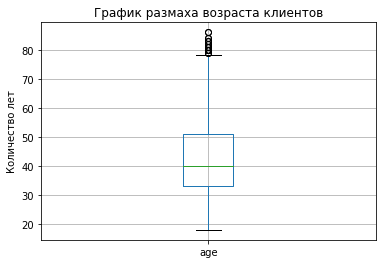

count   9,923.00
mean       42.73
std        12.18
min        18.00
25%        33.00
50%        40.00
75%        51.00
max        86.00
Name: age, dtype: float64

In [14]:
data.boxplot(column = 'age' , return_type='axes');
plt.title('График размаха возраста клиентов')
plt.ylabel('Количество лет')
plt.show()
data['age'].describe()

Видим, что по возрасту есть небольшие выбросы ,но они незначительные.Минимальный возраст 18 лет, что соответсвует законодательству. Максимальный возраст 86 лет.


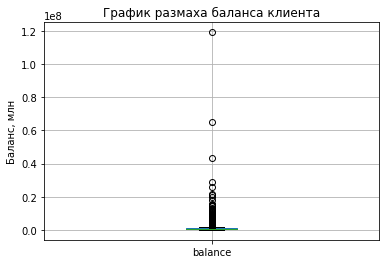

count         7,663.00
mean        828,248.16
std       1,984,247.69
min               0.00
25%         295,498.98
50%         524,961.22
75%         980,801.49
max     119,113,552.01
Name: balance, dtype: float64

In [15]:
data.boxplot(column = 'balance' , return_type='axes');
plt.title('График размаха баланса клиента')
plt.ylabel('Баланс, млн')
plt.show()
data['balance'].describe()

Из графика можно сделать вывод, что у  большинства клиентов баланс ниже 1 млн . Те клиенты , у которых баланс выше этой отметки будем считать вип-клиентами.

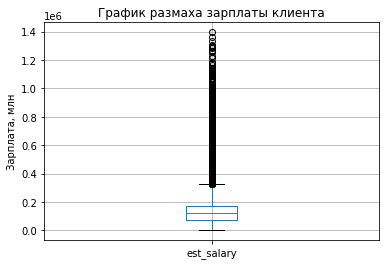

count       9,923.00
mean      147,886.49
std       139,363.90
min         2,546.30
25%        75,252.12
50%       119,719.33
75%       174,673.28
max     1,395,064.45
Name: est_salary, dtype: float64

In [16]:
data.boxplot(column = 'est_salary' , return_type='axes');
plt.title('График размаха зарплаты клиента')
plt.ylabel('Зарплата, млн')
plt.show()
data['est_salary'].describe()

Клиентов, имеющих доход свыше 300000 ,так же отнесем к категории вип-клиентов.

Затем посомтрим выбросы в столбце products

In [17]:
data['products'].describe()

count   9,923.00
mean        1.87
std         0.79
min         0.00
25%         1.00
50%         2.00
75%         2.00
max         5.00
Name: products, dtype: float64

Видим, что есть клиент или клиенты , которые вообще не пользуются продуктами банка. Найдем таких клиентов.

In [18]:
data.query('products == 0')

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
8957,147837,962.00,Рыбинск,Ж,79.00,3,NaN,0,0,0,"25,063.96",1


Видим, что есть клиент , который не пользуется продуктами банка, такой клиент один, поэтому можно удалить 

In [19]:
data=data.query('products != 0')

# **Исследовательский анализ данных**

Посмотрим распределение по некоторым параметрам

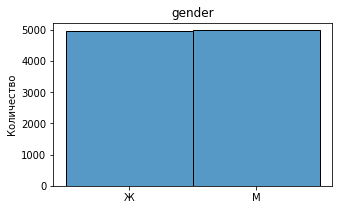

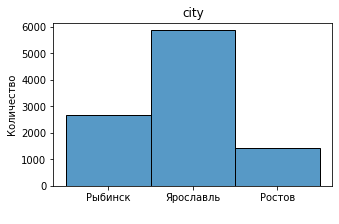

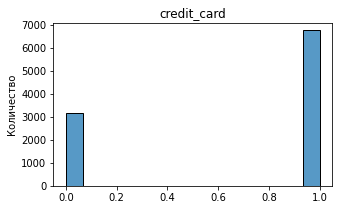

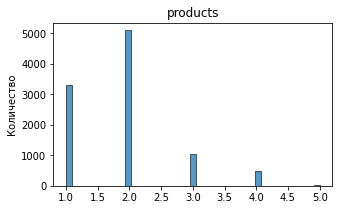

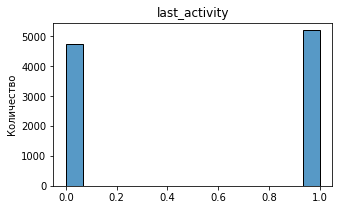

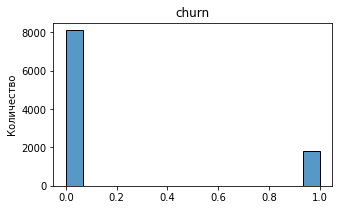

In [20]:
data_to_plt = data[[
    'gender', 'city', 'credit_card', 'products', 'last_activity', 'churn' ]]

for i in data_to_plt.columns:
        plt.figure(figsize=(5, 3))
        sns.histplot(x=i, data=data)
        plt.title(i)
        plt.xlabel(' ')
        plt.ylabel('Количество')
        plt.show()


Вывод: по графкам видно, что распределение по полу и активности примерно равное. В Ярославле самое большое количество клиентов в 2 раза больше , чем в Рыбинске , и в 3 раза больше , чем в Ростове. Клиенты,которые имеют кредитную карту примерно в 2 раза больше, чем без нее. Чуть больше трети клиентов пользуются одним продуктом, около 50% - двумя. 3, 4 и 5 продкутами - менее 5%. Так же около 20% клиентов уходит.

**ВЛИЯНИЕ ПАРАМЕТРОВ НА ОТТОК**

In [21]:
data.groupby('churn').agg('median')

,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary
churn,,,,,,,,,
0,"173,117.50",848.00,40.00,3.00,"475,354.80",2.00,1.00,0.00,"118,248.51"
1,"170,638.50",866.00,39.00,4.00,"783,908.90",2.00,1.00,1.00,"125,408.88"


Вывод:
- у тех кто ушел, рейтнг score выше , чем у тех , кто остался
- уходят клиенты со среднем возрастом 39 лет 
- в среднем баланс клиентов , которые ушли, больше , чем у тех кто остался
- оттточные клиенты имеют около двух продуктов банка

**МАТРИЦА КОРРЕЛЯЦИЙ**

Построим матрицу корреляций , для этого сначала создадим копию датасета, чтобы удалить столбец 'userid' так как от него нет никакой зависимости

Также необходимо учитывать города и пол, поэотому закодируем города в бинарной системе.

In [22]:
matrix = data
matrix = pd.get_dummies(matrix,columns=['city','gender'],drop_first=False)
matrix = matrix.rename(columns = {'city_Ростов':'Ростов','city_Рыбинск':'Рыбинск','city_Ярославль':'Ярославль'})

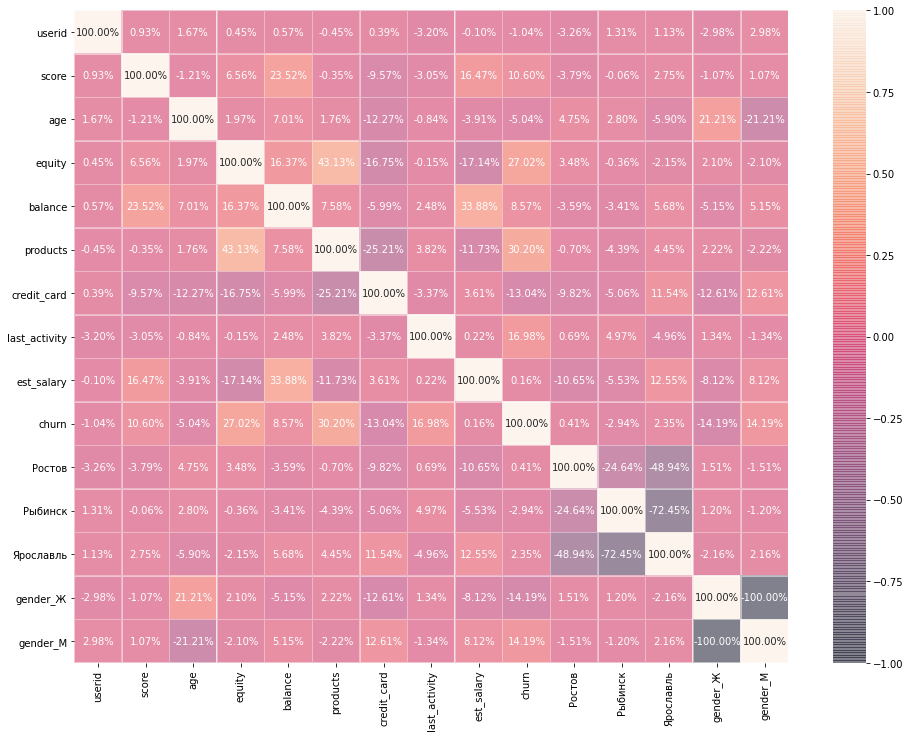

In [23]:
f, ax = plt.subplots(figsize=(16, 12))

sns.heatmap(matrix.corr(), annot=True, linewidths=.5,fmt='.2%', alpha=.5)
plt.show()

Вывод: по матрице корреляций видно, что сильной зависимости оттока клиента от других параметров - нет. Больше всего влияние на отток оказывают количество продуктов и оценка собственности. Стоит отметить , что есть умеренная корреляция между балансом и зароботной платы.Так же можно увидеть, что корреляции между городами и параметрами нет. Заметим , что корреляция между полом и оттоком низкая.

**СЕГМЕНТАЦИЯ ПОЛЬЗОВАТЕЛЕЙ ПО ПОТРЕБЛЕНИЮ ПРОДУКТОВ**

Далее рассмотрим, как распределяются пользователи по количеству потребляемых продуктов. То есть продукты , которые предоставляет сам банк.

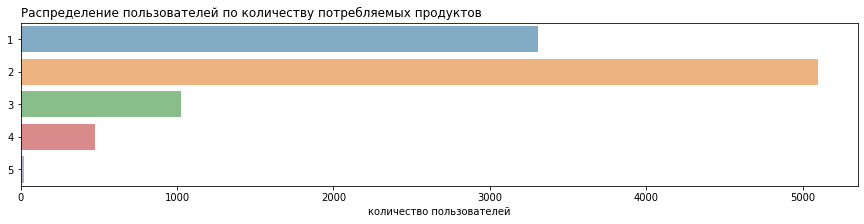

In [24]:
plt.figure(figsize=(15, 3))
ax = sns.barplot(x='count', 
                 y='products', 
                 data=data.groupby('products').agg(count=('userid','count')).reset_index(), 
                 orient='h', alpha=0.6)
ax.set_title('Распределение пользователей по количеству потребляемых продуктов', loc='left')
ax.set_xlabel('количество пользователей') 
ax.set_ylabel('')
plt.show()



Как видно из графика , больше клиентов, которые пользуются 2 продуктами , около 50%, одним продуктом пользуются примерно 32%, 3мя продуктами около 10% , 4мя продуктами около 5% и 5ю продуктами менее 1% процента.

In [25]:
data_product = data.groupby('products').agg('mean')
data_product

,userid,score,age,equity,balance,credit_card,last_activity,est_salary,churn
products,,,,,,,,,
1,"172,048.62",854.34,42.20,1.33,"611,243.03",0.86,0.53,"180,616.23",0.07
2,"171,416.61",844.60,42.75,3.15,"813,073.72",0.63,0.52,"130,534.96",0.19
3,"172,853.77",837.24,45.74,3.53,"997,180.63",0.35,0.42,"128,907.95",0.29
4,"170,869.86",878.27,39.78,4.15,"1,267,820.57",0.68,0.79,"148,788.95",0.63
5,"163,015.58",859.26,36.47,3.68,"610,986.63",1.00,0.89,"116,652.05",0.42


Из таблицы можно сделать вывод,что большой отток происходит у клиентов с 4мя и 5ю продуктами

После группировки пользователей по количеству потребляемых продуктов перейдем к сравнению параметров каждой группы методом boxplot().



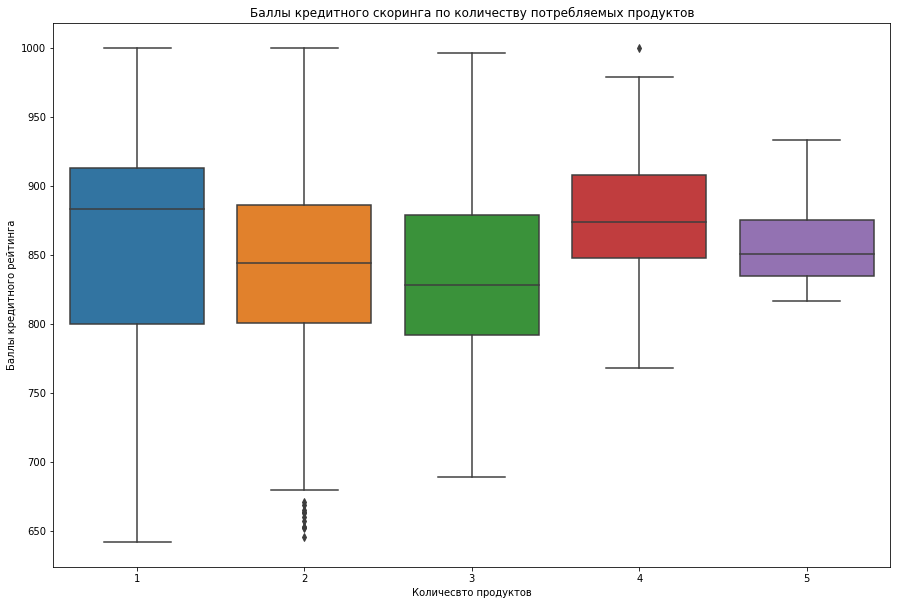

In [26]:
plt.figure(figsize=(15,10))
sns.boxplot(x='products', y = 'score', data = data)
ax = plt.gca()
ax.set_xlabel('Количесвто продуктов')
ax.set_ylabel('Баллы кредитного рейтинга')
ax.set_title('Баллы кредитного скоринга по количеству потребляемых продуктов');

**Вывод:** количество продуктов, не влияют на баллы кредитного скоринга клиента.

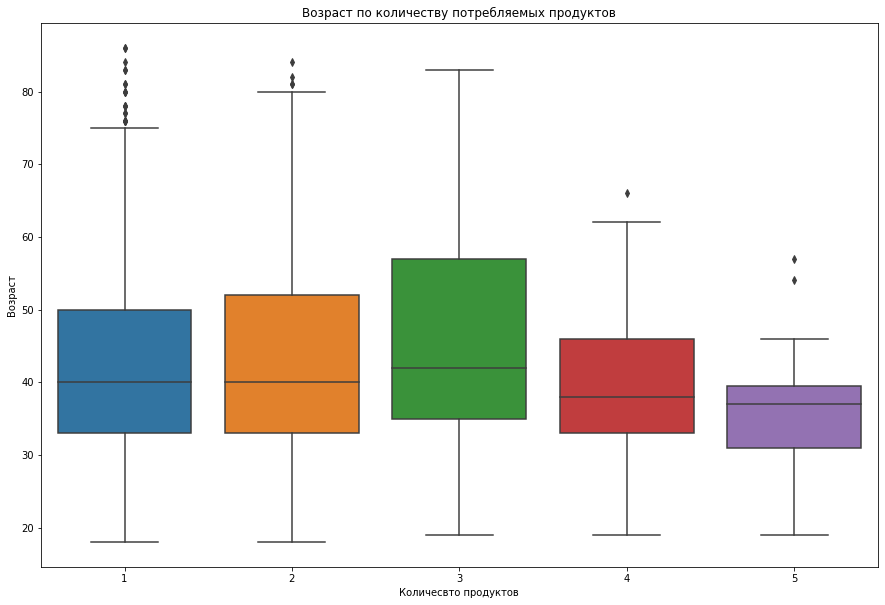

In [27]:
plt.figure(figsize=(15,10))
sns.boxplot(x='products', y = 'age', data = data)
ax = plt.gca()
ax.set_xlabel('Количесвто продуктов')
ax.set_ylabel('Возраст')
ax.set_title('Возраст по количеству потребляемых продуктов');

**Вывод:** возрастные клиенты обычно пользуются 3 продуктами банка. Однако мы видим выбросы , и с использованием одного продукта и 2 продуктов банка

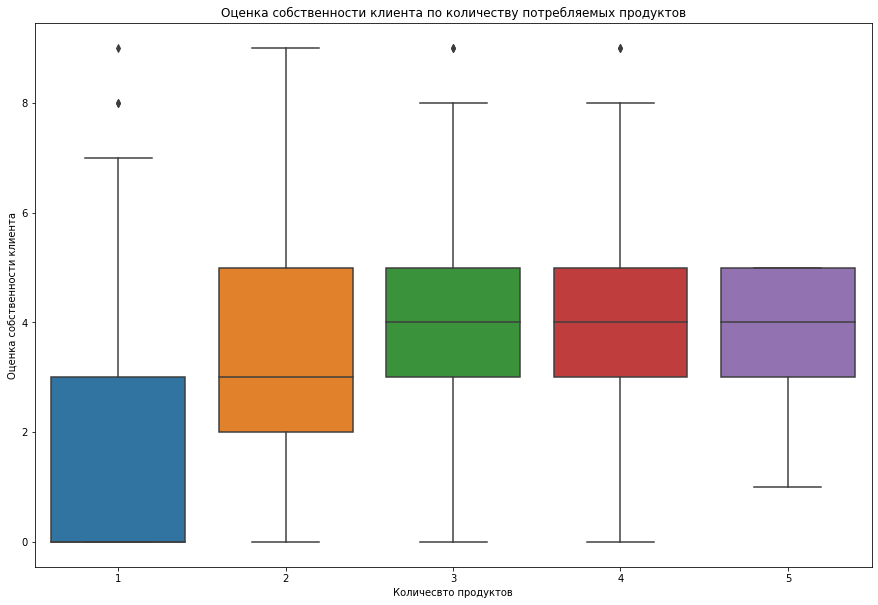

In [28]:
plt.figure(figsize=(15,10))
sns.boxplot(x='products', y = 'equity', data = data)
ax = plt.gca()
ax.set_xlabel('Количесвто продуктов')
ax.set_ylabel('Оценка собственности клиента')
ax.set_title('Оценка собственности клиента по количеству потребляемых продуктов');

**Вывод:** из графика видно, влияиние оценки собственности на количество продуктов. Клиенты , с оценкой от 0 до 3 , чаще всего пользуются одним продуктом. 

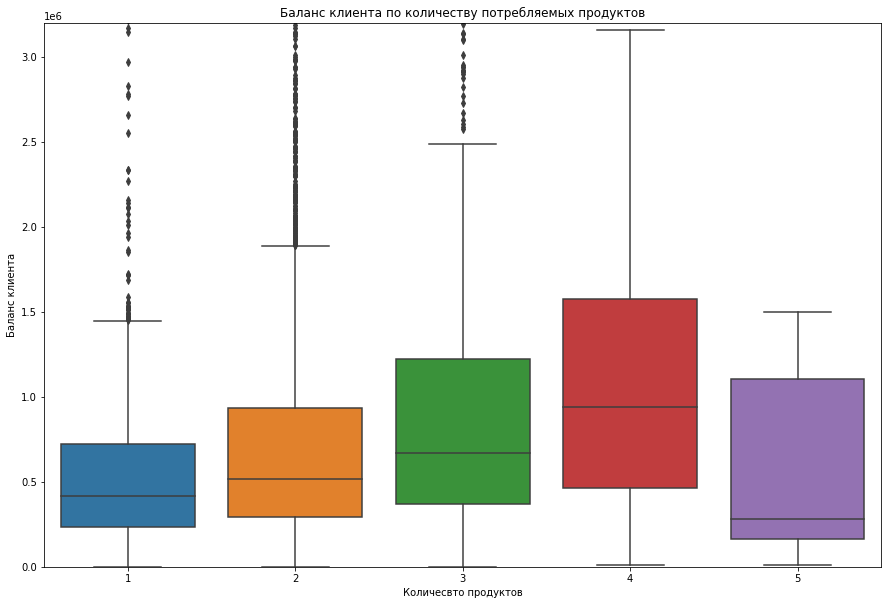

In [29]:
plt.figure(figsize=(15,10))
sns.boxplot(x='products', y = 'balance', data = data)
ax = plt.gca()
ax.set_xlabel('Количесвто продуктов')
ax.set_ylabel('Баланс клиента')
ax.set_title('Баланс клиента по количеству потребляемых продуктов')
ax.set(ylim=(0, 3200000));

**Вывод:** видно, чем больше баланс клиента, тем больше продуктов банка он использует. Но клиенты , которые используют 5 продуктов являются исключением, так как их небольшое количество в исследовании.

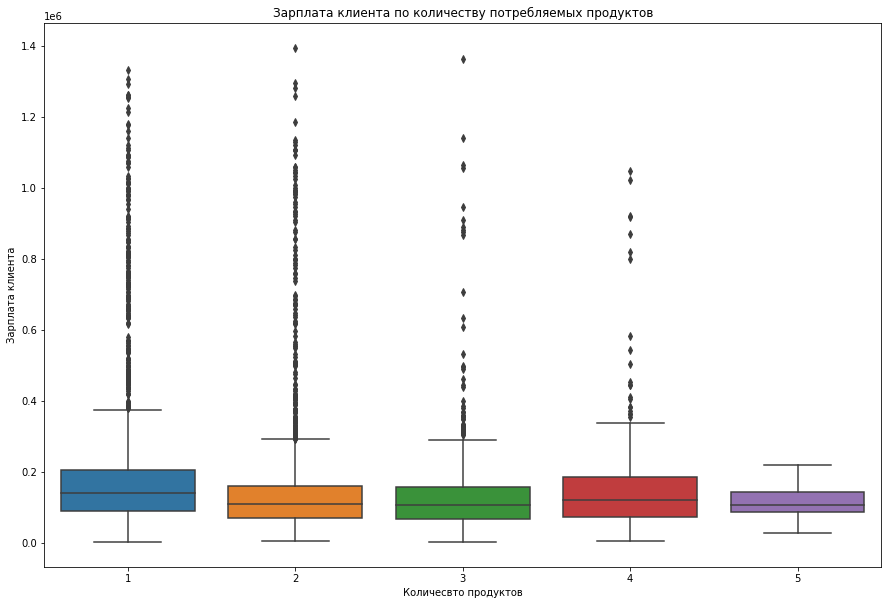

In [30]:
plt.figure(figsize=(15,10))
sns.boxplot(x='products', y = 'est_salary', data = data)
ax = plt.gca()
ax.set_xlabel('Количесвто продуктов')
ax.set_ylabel('Зарплата клиента')
ax.set_title('Зарплата клиента по количеству потребляемых продуктов');

**Вывод:** видим, что зарплата не влияет на количество продуктов , которые использует клиент

Далее посмотрим, на логические параметры. Для сравнения будем использовать столбчатые диаграммы.

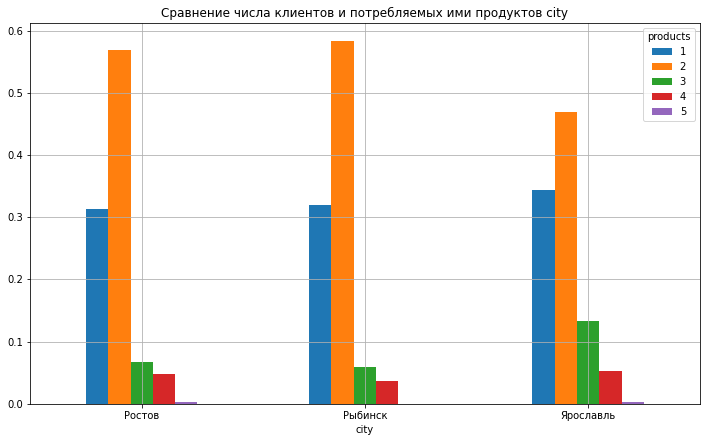

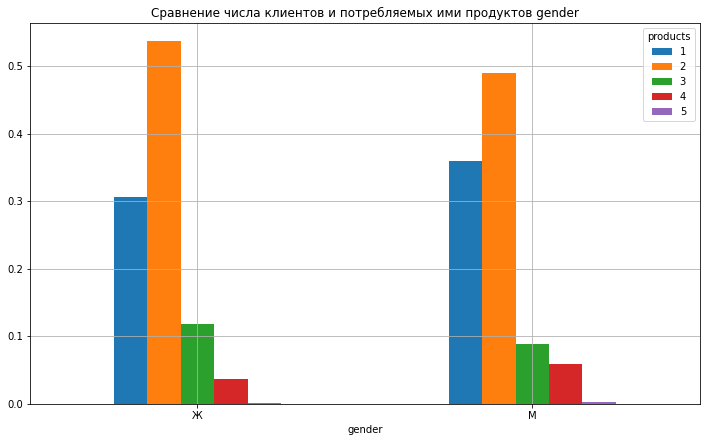

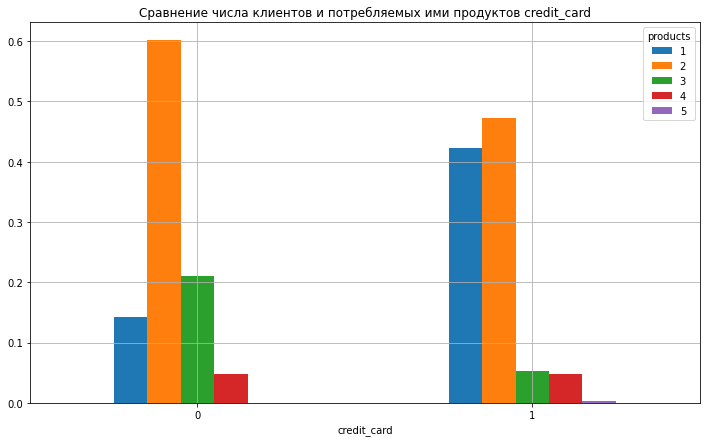

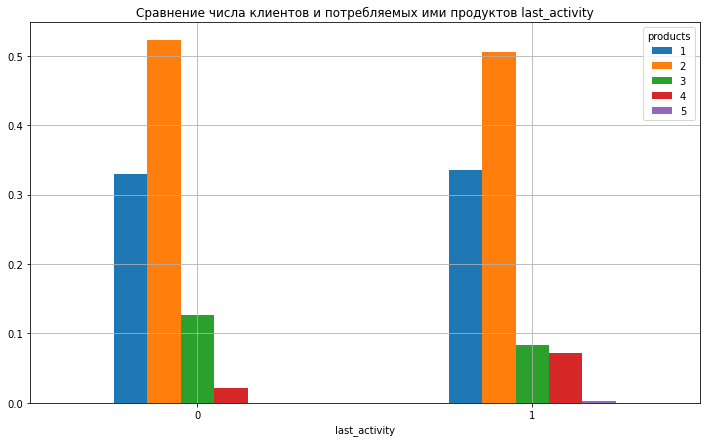

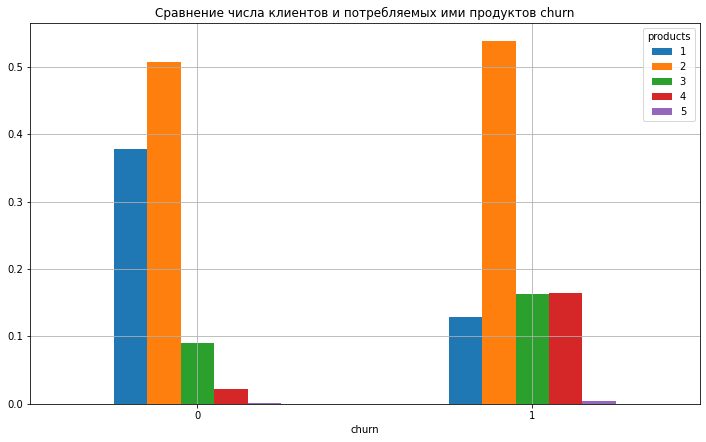

In [31]:
parametrs_rus = ['по городам', \
                  'в зависимости от пола', \
                  'в зависимости от наличия кредитной карты', \
                  'в зависимости от активности', \
                  'в зависимости от того, ушёл клиент или нет']
parametrs = ['city', 'gender', 'credit_card', 'last_activity', 'churn']
for i in range(len(parametrs)):
    data1 = data.pivot_table(index=parametrs[i], columns='products', values='userid', aggfunc='count')
    data1['sum'] = data1.sum(axis=1)
    for j in range(1, 6):
        data1[j] = data1[j] / data1['sum']
    data1.iloc[:, 0:5].plot(kind='bar', figsize=(12, 7), grid=True, 
                          title='Сравнение числа клиентов и потребляемых ими продуктов ' + parametrs[i])
    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    plt.show()

**Вывод:** как видно из столбчатой диаграммы ,в каждом городе клиентов с 2мя банковскими продуктами больше, чем остальных. Затем идут клиенты с одним продуктом.Видим ,больше женщин , которые пользуются двумя продуктами больше , чем мужчин. Также больше женщин , которые пользуются тремя продуктами. Однако мужчин пбольше, которые пользуются одним продуктом.Клиенты, которые используют кредитную карту, чаще всего пользуются двумя продуктами банка. Так же видим, много клиентов, которые пользуются только кредитной картой. По графикам видно, что число клиентов и потребляемые ими продукты не зависят от активности клиентов. Из тех клиентов, которые уходят, больше тех, кто пользуется двумя продуктами. Клиентов с идни, тремя и четырьмя продуктами примерно по ровну. Среди тех кто остлался , больше клиентов , которые пользуются дувмя продуктами, потом идут клиенты с одним продуктом, далее с 3мя продуктами, затем с 4мя продуктами и 5ю.

**Клиенты с одним продуктом:** 
- средний возраст 42 года,но высокий процент пенсионеров
- средняя сумма на балансе 611006, высокая волатильность
- средняя вероятность ухода, но 70% от общего числа ушедших клиентов
- чаще всего есть кредитная карта 
- средняя активность
- заработная плата около 180000
- среднее число баллов кредитного скоринга, но часто ниже.

**Клиенты с двумя продуктами:**
- средний возраст 42, но высокий процент пенсионеров
- средняя сумма на балансе 812000, высокая волатильность
- наименьшая вероятность ухода
- чаще всего есть кредитная карта
- активность выше среднего
- заработная плата средняя
- среднее число баллов кредитного скоринга.

**Клиенты с тремя продуктами:** 
- средний возраст 45, процент пенсионеров ниже среднего
- средняя сумма на балансе 993, волатильность ниже среднего
- 30% клиентов ушли
- кредитной карты скорее нет
- активность ниже среднего 
- заработная плата выше среднего
- среднее число баллов кредитного скоринга.

**Клиенты с четырьмя продуктами:**
- Средний возраст 39, процент пенсионеров низкий
- средняя сумма на балансе 1267820 — выше, чем у остальных групп, волатильность низкая
- 63% клиентов ушли 
- чаще всего есть кредитная карта
- активность выше среднего
- заработная плата выше среднего
- среднее число баллов кредитного скоринга.

**Клиенты с пятью продуктами:**
- средний возраст 36, процент пенсионеров низкий
- средняя сумма на балансе 610986
- 42% клиентов ушли
- у всех клиентов есть кредитная карта
- активность выше среднего
- среднее число баллов кредитного скоринга.

**Проверка гипотез**

Гипотеза 1

В ходе исследования нам необходимо проверить гипотезу о том , что **возраст клиентов, которые пользуются двумя продуктами банка, равен возрасту клиентов, которые пользуются одним.**

Воспользуемся критерием Манна-Уитни,поскольку он не требует нормального распределения выборок.

Обозначим основную и альтернативную гипотезу.

**H_0:** возраст клиентов, которые пользуются двумя продуктами банка, равен возрасту клиентов, которые пользуются одним.

**H_1:** возраст клиентов, которые пользуются двумя продуктами банка, не равен возрасту клиентов, которые пользуются одним.

Уровень значимости зададим 0,05

Если p-value будет меньше выбранного уровня значимости , то нулевую гипотезу о равенстве средних отвергнем. В противном случае делаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [32]:
data1 = data[data['products'] < 2]['age']
data2 = data[data['products'] == 2]['age']

alpha = .05 # критический уровень статистической значимости

results = st.mannwhitneyu(data2,data1)
print('p-значение: ', "{0:.3f}".format(results.pvalue))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.072
Не получилось отвергнуть нулевую гипотезу


Мы не отвергаем гипотезу о том, что средний возраст клиентов, которые пользуются двумя продуктами банка, равен среднему возрасту клиентов, которые пользуются одним.

**Гипотеза 2**

Также в ходе исследования необходимо проверить вторую гипотезу о том, что **доход клиентов, которые пользуются двумя продуктами банка, равен доходу клиентов, которые пользуются одним.**

Обозначим основную и альтернативную гипотезу.

H_0 : Доход клиентов, которые
пользуются двумя продуктами банка, равен доходу клиентов, которые пользуются одним.

H_1 :  доход клиентов, которые
пользуются двумя продуктами банка, равен  доходу клиентов, которые пользуются одним.

Воспользуемся критерием Манна-Уитни,поскольку он не требует нормального распределения выборок.

Уровень значимости зададим 0,05


In [33]:
data1 = data[data['products'] < 2]['est_salary']
data2 = data[data['products'] == 2]['est_salary']
alpha = 0.01   # критический уровень статистической значимости    
results = st.mannwhitneyu(data1,data2)

print('p-значение: ', results.pvalue)    # тест двухсторонний

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  8.20292999918016e-77
Отвергаем нулевую гипотезу


Мы отвергаем гипотезу о том, что доход клиентов, которые пользуются двумя продуктами банка, равен доходу клиентов, которые пользуются одним.

Главное отличие u-критерия Манна-Уитни от t-критерия Стьюдента в том, что он работает с рангами, — номерами значений в упорядоченном ряду, — никак не учитывая сами значения. Поэтому им пользуются тогда, когда работа с самими значениями невозможна из-за выбросов, сильно сдвигающих результаты.

**ВЫВОДЫ И РЕКОМЕНДАЦИИ**

В ходе исследования был проанализирован датасет клиентов банка "Метанпром", обслуживающихся в отделениях Ярославля, Ростове и Рыбинске.

Клиенты банка могут использовать от одного до пяти банковских продуктов. По набору полей (скоринг, ЗП, наличие недвижимости в собственности) можно предположить, что речь идет о кредитных продуктах банка (ипотека, потребительский кредит, автокредит, покупка товаров в рассрочку и т.д.).

Распределили клиентов на несколько групп

**Клиенты с одним продуктом:** средний возраст 42 года,но высокий процент пенсионеров ,средняя сумма на балансе 611 006, высокая волатильность, средняя вероятность ухода, но 70% от общего числа ушедших клиентов, чаще всего есть кредитная карта, средняя активность , заработная плата около 180 000 , среднее число баллов кредитного скоринга, но часто ниже.
**Клиенты с двумя продуктами:** средний возраст 42, но высокий процент пенсионеров, средняя сумма на балансе 812 000, высокая, волатильность, наименьшая вероятность ухода, чаще всего есть кредитная карта, активность выше среднего, заработная плата средняя
, среднее число баллов кредитного скоринга
**Клиенты с тремя продуктами:** средний возраст 45, процент пенсионеров ниже среднего, средняя сумма на балансе 993 000, волатильность ниже среднего, 30% клиентов ушли, кредитной карты скорее нет, активность ниже среднего, заработная плата выше среднего, среднее число баллов кредитного скоринга.
**Клиенты с четырьмя продуктами:** средний возраст 39, процент пенсионеров низкий, средняя сумма на балансе 1 267 820 — выше, чем у остальных групп, волатильность низкая, 63% клиентов ушли, чаще всего есть кредитная карта, активность выше среднего, заработная плата выше среднего, среднее число баллов кредитного скоринга.
**Клиенты с пятью продуктами:** средний возраст 36, процент пенсионеров низкий, средняя сумма на балансе 610 986, 42% клиентов ушли, у всех клиентов есть кредитная карта, активность выше среднего, среднее число баллов кредитного скоринга.

Далее проверили две гипотезы:

- возраст клиентов, которые пользуются двумя продуктами банка, равен возрасту клиентов, которые пользуются одним.

- доход клиентов, которые пользуются двумя продуктами банка, равен доходу клиентов, которые пользуются одним.

Первую гипотезу отвергнуть не получилсоь,вторую гипотезу отвергли.

Клиентам с одним продуктом, необходимо сделать лояльные условия пользования кредитной картой

Для клиентов, пользующиеся двумя продуктами, можно создать программы для привлечения молодежи, для того чтобы омолодить сегмент.Как пример льготный кредит молодым семьям. 

На отток также влияет активность клиентов. Стоит пользоваться программами лояльности, например, предлагать повышенный кэшбек в некоторых категориях, снижение комиссий за перевод по определённым дням.Нужно получить обратную связь от клиентов, расторгнувших договор. Может будут негативыне отзывы не на продукты, а на персонал. 

Для клиентов, имеющих 3-4 продукта необходимо провести консолидацию долга с некоторым снижением процентной ставки (консолидация кредитов – это комплекс банковских мероприятий по объединению нескольких кредитов и займов в один). Это поможет удержать клиентов, т.к. снизят нагрузку на плательщика. В противном случае клиенты уйдут в первую же кредитную организацию, которая сделает им такое предложение.